# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 10)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3893 / G_loss : 0.6783
- D(x) : 0.4994 / D(G(z1)) : 0.5008 / D(G(z2)) : 0.5075
[1/100][1/14]
- D_loss : 1.3929 / G_loss : 0.6708
- D(x) : 0.5002 / D(G(z1)) : 0.5034 / D(G(z2)) : 0.5113
[1/100][2/14]
- D_loss : 1.3967 / G_loss : 0.6635
- D(x) : 0.5022 / D(G(z1)) : 0.5073 / D(G(z2)) : 0.5151
[1/100][3/14]
- D_loss : 1.4019 / G_loss : 0.6591
- D(x) : 0.5017 / D(G(z1)) : 0.5094 / D(G(z2)) : 0.5173
[1/100][4/14]
- D_loss : 1.4080 / G_loss : 0.6523
- D(x) : 0.5023 / D(G(z1)) : 0.5129 / D(G(z2)) : 0.5209
[1/100][5/14]
- D_loss : 1.4136 / G_loss : 0.6456
- D(x) : 0.5034 / D(G(z1)) : 0.5167 / D(G(z2)) : 0.5244
[1/100][6/14]
- D_loss : 1.4216 / G_loss : 0.6412
- D(x) : 0.5023 / D(G(z1)) : 0.5195 / D(G(z2)) : 0.5267
[1/100][7/14]
- D_loss : 1.4275 / G_loss : 0.6356
- D(x) : 0.5030 / D(G(z1)) : 0.5230 / D(G(z2)) : 0.5296
[1/100][8/14]
- D_loss : 1.4310 / G_loss : 0.6307
- D(x) : 0.5042 / D(G(z1)) : 0.5258 / D(G(z2)) : 0.5322
[1/100][9/14]
- D_loss : 1.4342 / G_loss : 0.6

[6/100][8/14]
- D_loss : 1.5003 / G_loss : 0.5565
- D(x) : 0.5217 / D(G(z1)) : 0.5723 / D(G(z2)) : 0.5732
[6/100][9/14]
- D_loss : 1.5007 / G_loss : 0.5562
- D(x) : 0.5221 / D(G(z1)) : 0.5728 / D(G(z2)) : 0.5734
[6/100][10/14]
- D_loss : 1.5000 / G_loss : 0.5569
- D(x) : 0.5223 / D(G(z1)) : 0.5727 / D(G(z2)) : 0.5730
[6/100][11/14]
- D_loss : 1.5020 / G_loss : 0.5572
- D(x) : 0.5212 / D(G(z1)) : 0.5727 / D(G(z2)) : 0.5728
[6/100][12/14]
- D_loss : 1.4991 / G_loss : 0.5567
- D(x) : 0.5230 / D(G(z1)) : 0.5729 / D(G(z2)) : 0.5731
[6/100][13/14]
- D_loss : 1.4988 / G_loss : 0.5570
- D(x) : 0.5226 / D(G(z1)) : 0.5725 / D(G(z2)) : 0.5729
[7/100][0/14]
- D_loss : 1.4974 / G_loss : 0.5565
- D(x) : 0.5234 / D(G(z1)) : 0.5725 / D(G(z2)) : 0.5732
[7/100][1/14]
- D_loss : 1.5060 / G_loss : 0.5549
- D(x) : 0.5200 / D(G(z1)) : 0.5734 / D(G(z2)) : 0.5741
[7/100][2/14]
- D_loss : 1.4973 / G_loss : 0.5548
- D(x) : 0.5250 / D(G(z1)) : 0.5737 / D(G(z2)) : 0.5742
[7/100][3/14]
- D_loss : 1.5003 / G_loss :

[12/100][1/14]
- D_loss : 1.5074 / G_loss : 0.5447
- D(x) : 0.5282 / D(G(z1)) : 0.5805 / D(G(z2)) : 0.5800
[12/100][2/14]
- D_loss : 1.5001 / G_loss : 0.5456
- D(x) : 0.5313 / D(G(z1)) : 0.5800 / D(G(z2)) : 0.5795
[12/100][3/14]
- D_loss : 1.5101 / G_loss : 0.5467
- D(x) : 0.5252 / D(G(z1)) : 0.5793 / D(G(z2)) : 0.5789
[12/100][4/14]
- D_loss : 1.5037 / G_loss : 0.5482
- D(x) : 0.5280 / D(G(z1)) : 0.5788 / D(G(z2)) : 0.5780
[12/100][5/14]
- D_loss : 1.5014 / G_loss : 0.5493
- D(x) : 0.5283 / D(G(z1)) : 0.5781 / D(G(z2)) : 0.5773
[12/100][6/14]
- D_loss : 1.5018 / G_loss : 0.5507
- D(x) : 0.5269 / D(G(z1)) : 0.5771 / D(G(z2)) : 0.5765
[12/100][7/14]
- D_loss : 1.4933 / G_loss : 0.5514
- D(x) : 0.5308 / D(G(z1)) : 0.5767 / D(G(z2)) : 0.5761
[12/100][8/14]
- D_loss : 1.4942 / G_loss : 0.5522
- D(x) : 0.5295 / D(G(z1)) : 0.5760 / D(G(z2)) : 0.5757
[12/100][9/14]
- D_loss : 1.4947 / G_loss : 0.5529
- D(x) : 0.5286 / D(G(z1)) : 0.5755 / D(G(z2)) : 0.5753
[12/100][10/14]
- D_loss : 1.5033 / G

[17/100][8/14]
- D_loss : 1.4897 / G_loss : 0.5596
- D(x) : 0.5258 / D(G(z1)) : 0.5711 / D(G(z2)) : 0.5714
[17/100][9/14]
- D_loss : 1.4925 / G_loss : 0.5599
- D(x) : 0.5243 / D(G(z1)) : 0.5711 / D(G(z2)) : 0.5712
[17/100][10/14]
- D_loss : 1.4832 / G_loss : 0.5611
- D(x) : 0.5288 / D(G(z1)) : 0.5708 / D(G(z2)) : 0.5706
[17/100][11/14]
- D_loss : 1.4829 / G_loss : 0.5626
- D(x) : 0.5280 / D(G(z1)) : 0.5700 / D(G(z2)) : 0.5697
[17/100][12/14]
- D_loss : 1.4865 / G_loss : 0.5644
- D(x) : 0.5252 / D(G(z1)) : 0.5693 / D(G(z2)) : 0.5687
[17/100][13/14]
- D_loss : 1.4817 / G_loss : 0.5662
- D(x) : 0.5262 / D(G(z1)) : 0.5679 / D(G(z2)) : 0.5677
[18/100][0/14]
- D_loss : 1.4765 / G_loss : 0.5665
- D(x) : 0.5280 / D(G(z1)) : 0.5672 / D(G(z2)) : 0.5675
[18/100][1/14]
- D_loss : 1.4758 / G_loss : 0.5650
- D(x) : 0.5286 / D(G(z1)) : 0.5674 / D(G(z2)) : 0.5683
[18/100][2/14]
- D_loss : 1.4794 / G_loss : 0.5653
- D(x) : 0.5260 / D(G(z1)) : 0.5669 / D(G(z2)) : 0.5682
[18/100][3/14]
- D_loss : 1.4896 

[23/100][1/14]
- D_loss : 1.4954 / G_loss : 0.5560
- D(x) : 0.5254 / D(G(z1)) : 0.5732 / D(G(z2)) : 0.5735
[23/100][2/14]
- D_loss : 1.4922 / G_loss : 0.5576
- D(x) : 0.5259 / D(G(z1)) : 0.5722 / D(G(z2)) : 0.5726
[23/100][3/14]
- D_loss : 1.4928 / G_loss : 0.5582
- D(x) : 0.5251 / D(G(z1)) : 0.5718 / D(G(z2)) : 0.5723
[23/100][4/14]
- D_loss : 1.4888 / G_loss : 0.5587
- D(x) : 0.5268 / D(G(z1)) : 0.5715 / D(G(z2)) : 0.5720
[23/100][5/14]
- D_loss : 1.4867 / G_loss : 0.5588
- D(x) : 0.5276 / D(G(z1)) : 0.5712 / D(G(z2)) : 0.5719
[23/100][6/14]
- D_loss : 1.4875 / G_loss : 0.5592
- D(x) : 0.5267 / D(G(z1)) : 0.5709 / D(G(z2)) : 0.5717
[23/100][7/14]
- D_loss : 1.4893 / G_loss : 0.5589
- D(x) : 0.5259 / D(G(z1)) : 0.5710 / D(G(z2)) : 0.5719
[23/100][8/14]
- D_loss : 1.4948 / G_loss : 0.5584
- D(x) : 0.5231 / D(G(z1)) : 0.5711 / D(G(z2)) : 0.5721
[23/100][9/14]
- D_loss : 1.4955 / G_loss : 0.5578
- D(x) : 0.5230 / D(G(z1)) : 0.5714 / D(G(z2)) : 0.5725
[23/100][10/14]
- D_loss : 1.4883 / G

[28/100][8/14]
- D_loss : 1.4589 / G_loss : 0.5830
- D(x) : 0.5268 / D(G(z1)) : 0.5585 / D(G(z2)) : 0.5583
[28/100][9/14]
- D_loss : 1.4652 / G_loss : 0.5840
- D(x) : 0.5228 / D(G(z1)) : 0.5580 / D(G(z2)) : 0.5577
[28/100][10/14]
- D_loss : 1.4528 / G_loss : 0.5858
- D(x) : 0.5283 / D(G(z1)) : 0.5570 / D(G(z2)) : 0.5567
[28/100][11/14]
- D_loss : 1.4552 / G_loss : 0.5868
- D(x) : 0.5263 / D(G(z1)) : 0.5564 / D(G(z2)) : 0.5561
[28/100][12/14]
- D_loss : 1.4544 / G_loss : 0.5879
- D(x) : 0.5258 / D(G(z1)) : 0.5556 / D(G(z2)) : 0.5555
[28/100][13/14]
- D_loss : 1.4501 / G_loss : 0.5891
- D(x) : 0.5273 / D(G(z1)) : 0.5550 / D(G(z2)) : 0.5548
[29/100][0/14]
- D_loss : 1.4447 / G_loss : 0.5902
- D(x) : 0.5297 / D(G(z1)) : 0.5546 / D(G(z2)) : 0.5542
[29/100][1/14]
- D_loss : 1.4561 / G_loss : 0.5915
- D(x) : 0.5226 / D(G(z1)) : 0.5537 / D(G(z2)) : 0.5535
[29/100][2/14]
- D_loss : 1.4481 / G_loss : 0.5925
- D(x) : 0.5259 / D(G(z1)) : 0.5529 / D(G(z2)) : 0.5530
[29/100][3/14]
- D_loss : 1.4474 

[34/100][1/14]
- D_loss : 1.4331 / G_loss : 0.6122
- D(x) : 0.5214 / D(G(z1)) : 0.5422 / D(G(z2)) : 0.5422
[34/100][2/14]
- D_loss : 1.4178 / G_loss : 0.6131
- D(x) : 0.5290 / D(G(z1)) : 0.5419 / D(G(z2)) : 0.5417
[34/100][3/14]
- D_loss : 1.4188 / G_loss : 0.6136
- D(x) : 0.5279 / D(G(z1)) : 0.5414 / D(G(z2)) : 0.5414
[34/100][4/14]
- D_loss : 1.4122 / G_loss : 0.6140
- D(x) : 0.5311 / D(G(z1)) : 0.5411 / D(G(z2)) : 0.5412
[34/100][5/14]
- D_loss : 1.4194 / G_loss : 0.6146
- D(x) : 0.5270 / D(G(z1)) : 0.5409 / D(G(z2)) : 0.5409
[34/100][6/14]
- D_loss : 1.4232 / G_loss : 0.6149
- D(x) : 0.5249 / D(G(z1)) : 0.5408 / D(G(z2)) : 0.5407
[34/100][7/14]
- D_loss : 1.4227 / G_loss : 0.6152
- D(x) : 0.5249 / D(G(z1)) : 0.5405 / D(G(z2)) : 0.5406
[34/100][8/14]
- D_loss : 1.4156 / G_loss : 0.6153
- D(x) : 0.5283 / D(G(z1)) : 0.5402 / D(G(z2)) : 0.5405
[34/100][9/14]
- D_loss : 1.4140 / G_loss : 0.6145
- D(x) : 0.5294 / D(G(z1)) : 0.5404 / D(G(z2)) : 0.5409
[34/100][10/14]
- D_loss : 1.4214 / G

[39/100][8/14]
- D_loss : 1.4108 / G_loss : 0.6179
- D(x) : 0.5302 / D(G(z1)) : 0.5396 / D(G(z2)) : 0.5391
[39/100][9/14]
- D_loss : 1.4167 / G_loss : 0.6191
- D(x) : 0.5265 / D(G(z1)) : 0.5391 / D(G(z2)) : 0.5384
[39/100][10/14]
- D_loss : 1.4154 / G_loss : 0.6202
- D(x) : 0.5262 / D(G(z1)) : 0.5383 / D(G(z2)) : 0.5378
[39/100][11/14]
- D_loss : 1.4185 / G_loss : 0.6210
- D(x) : 0.5241 / D(G(z1)) : 0.5378 / D(G(z2)) : 0.5374
[39/100][12/14]
- D_loss : 1.4062 / G_loss : 0.6211
- D(x) : 0.5302 / D(G(z1)) : 0.5375 / D(G(z2)) : 0.5374
[39/100][13/14]
- D_loss : 1.4132 / G_loss : 0.6214
- D(x) : 0.5263 / D(G(z1)) : 0.5374 / D(G(z2)) : 0.5372
[40/100][0/14]
- D_loss : 1.4138 / G_loss : 0.6216
- D(x) : 0.5260 / D(G(z1)) : 0.5372 / D(G(z2)) : 0.5371
[40/100][1/14]
- D_loss : 1.4102 / G_loss : 0.6220
- D(x) : 0.5277 / D(G(z1)) : 0.5372 / D(G(z2)) : 0.5369
[40/100][2/14]
- D_loss : 1.4189 / G_loss : 0.6227
- D(x) : 0.5228 / D(G(z1)) : 0.5368 / D(G(z2)) : 0.5365
[40/100][3/14]
- D_loss : 1.4121 

[45/100][1/14]
- D_loss : 1.4341 / G_loss : 0.6279
- D(x) : 0.5118 / D(G(z1)) : 0.5341 / D(G(z2)) : 0.5337
[45/100][2/14]
- D_loss : 1.4202 / G_loss : 0.6279
- D(x) : 0.5186 / D(G(z1)) : 0.5338 / D(G(z2)) : 0.5337
[45/100][3/14]
- D_loss : 1.4280 / G_loss : 0.6283
- D(x) : 0.5147 / D(G(z1)) : 0.5339 / D(G(z2)) : 0.5335
[45/100][4/14]
- D_loss : 1.4284 / G_loss : 0.6293
- D(x) : 0.5140 / D(G(z1)) : 0.5336 / D(G(z2)) : 0.5330
[45/100][5/14]
- D_loss : 1.4340 / G_loss : 0.6307
- D(x) : 0.5105 / D(G(z1)) : 0.5329 / D(G(z2)) : 0.5322
[45/100][6/14]
- D_loss : 1.4361 / G_loss : 0.6320
- D(x) : 0.5086 / D(G(z1)) : 0.5322 / D(G(z2)) : 0.5315
[45/100][7/14]
- D_loss : 1.4227 / G_loss : 0.6335
- D(x) : 0.5146 / D(G(z1)) : 0.5314 / D(G(z2)) : 0.5307
[45/100][8/14]
- D_loss : 1.4269 / G_loss : 0.6348
- D(x) : 0.5118 / D(G(z1)) : 0.5308 / D(G(z2)) : 0.5300
[45/100][9/14]
- D_loss : 1.4324 / G_loss : 0.6364
- D(x) : 0.5081 / D(G(z1)) : 0.5300 / D(G(z2)) : 0.5292
[45/100][10/14]
- D_loss : 1.4188 / G

[50/100][8/14]
- D_loss : 1.3934 / G_loss : 0.6757
- D(x) : 0.5060 / D(G(z1)) : 0.5093 / D(G(z2)) : 0.5088
[50/100][9/14]
- D_loss : 1.3898 / G_loss : 0.6766
- D(x) : 0.5073 / D(G(z1)) : 0.5088 / D(G(z2)) : 0.5084
[50/100][10/14]
- D_loss : 1.3846 / G_loss : 0.6775
- D(x) : 0.5095 / D(G(z1)) : 0.5083 / D(G(z2)) : 0.5079
[50/100][11/14]
- D_loss : 1.3843 / G_loss : 0.6784
- D(x) : 0.5092 / D(G(z1)) : 0.5079 / D(G(z2)) : 0.5074
[50/100][12/14]
- D_loss : 1.3864 / G_loss : 0.6789
- D(x) : 0.5076 / D(G(z1)) : 0.5074 / D(G(z2)) : 0.5072
[50/100][13/14]
- D_loss : 1.3797 / G_loss : 0.6793
- D(x) : 0.5107 / D(G(z1)) : 0.5072 / D(G(z2)) : 0.5069
[51/100][0/14]
- D_loss : 1.3863 / G_loss : 0.6794
- D(x) : 0.5072 / D(G(z1)) : 0.5070 / D(G(z2)) : 0.5069
[51/100][1/14]
- D_loss : 1.3919 / G_loss : 0.6790
- D(x) : 0.5045 / D(G(z1)) : 0.5070 / D(G(z2)) : 0.5071
[51/100][2/14]
- D_loss : 1.3846 / G_loss : 0.6780
- D(x) : 0.5083 / D(G(z1)) : 0.5072 / D(G(z2)) : 0.5076
[51/100][3/14]
- D_loss : 1.3869 

[56/100][1/14]
- D_loss : 1.3743 / G_loss : 0.6990
- D(x) : 0.5033 / D(G(z1)) : 0.4972 / D(G(z2)) : 0.4971
[56/100][2/14]
- D_loss : 1.3698 / G_loss : 0.6981
- D(x) : 0.5056 / D(G(z1)) : 0.4972 / D(G(z2)) : 0.4975
[56/100][3/14]
- D_loss : 1.3681 / G_loss : 0.6965
- D(x) : 0.5069 / D(G(z1)) : 0.4977 / D(G(z2)) : 0.4983
[56/100][4/14]
- D_loss : 1.3810 / G_loss : 0.6950
- D(x) : 0.5012 / D(G(z1)) : 0.4984 / D(G(z2)) : 0.4991
[56/100][5/14]
- D_loss : 1.3747 / G_loss : 0.6940
- D(x) : 0.5052 / D(G(z1)) : 0.4993 / D(G(z2)) : 0.4996
[56/100][6/14]
- D_loss : 1.3761 / G_loss : 0.6939
- D(x) : 0.5049 / D(G(z1)) : 0.4997 / D(G(z2)) : 0.4996
[56/100][7/14]
- D_loss : 1.3786 / G_loss : 0.6943
- D(x) : 0.5037 / D(G(z1)) : 0.4997 / D(G(z2)) : 0.4994
[56/100][8/14]
- D_loss : 1.3721 / G_loss : 0.6938
- D(x) : 0.5068 / D(G(z1)) : 0.4996 / D(G(z2)) : 0.4997
[56/100][9/14]
- D_loss : 1.3753 / G_loss : 0.6922
- D(x) : 0.5055 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5005
[56/100][10/14]
- D_loss : 1.3826 / G

[61/100][8/14]
- D_loss : 1.3942 / G_loss : 0.6766
- D(x) : 0.5058 / D(G(z1)) : 0.5096 / D(G(z2)) : 0.5083
[61/100][9/14]
- D_loss : 1.3908 / G_loss : 0.6793
- D(x) : 0.5063 / D(G(z1)) : 0.5083 / D(G(z2)) : 0.5070
[61/100][10/14]
- D_loss : 1.3862 / G_loss : 0.6823
- D(x) : 0.5071 / D(G(z1)) : 0.5069 / D(G(z2)) : 0.5054
[61/100][11/14]
- D_loss : 1.3900 / G_loss : 0.6853
- D(x) : 0.5037 / D(G(z1)) : 0.5054 / D(G(z2)) : 0.5039
[61/100][12/14]
- D_loss : 1.3798 / G_loss : 0.6885
- D(x) : 0.5072 / D(G(z1)) : 0.5038 / D(G(z2)) : 0.5023
[61/100][13/14]
- D_loss : 1.3832 / G_loss : 0.6917
- D(x) : 0.5038 / D(G(z1)) : 0.5021 / D(G(z2)) : 0.5007
[62/100][0/14]
- D_loss : 1.3833 / G_loss : 0.6948
- D(x) : 0.5023 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.4992
[62/100][1/14]
- D_loss : 1.3732 / G_loss : 0.6980
- D(x) : 0.5058 / D(G(z1)) : 0.4991 / D(G(z2)) : 0.4976
[62/100][2/14]
- D_loss : 1.3683 / G_loss : 0.7011
- D(x) : 0.5066 / D(G(z1)) : 0.4975 / D(G(z2)) : 0.4960
[62/100][3/14]
- D_loss : 1.3644 

[67/100][1/14]
- D_loss : 1.3432 / G_loss : 0.7109
- D(x) : 0.5125 / D(G(z1)) : 0.4906 / D(G(z2)) : 0.4912
[67/100][2/14]
- D_loss : 1.3521 / G_loss : 0.7048
- D(x) : 0.5086 / D(G(z1)) : 0.4914 / D(G(z2)) : 0.4942
[67/100][3/14]
- D_loss : 1.3605 / G_loss : 0.6871
- D(x) : 0.5083 / D(G(z1)) : 0.4952 / D(G(z2)) : 0.5030
[67/100][4/14]
- D_loss : 1.3757 / G_loss : 0.6827
- D(x) : 0.5090 / D(G(z1)) : 0.5035 / D(G(z2)) : 0.5052
[67/100][5/14]
- D_loss : 1.3739 / G_loss : 0.6823
- D(x) : 0.5119 / D(G(z1)) : 0.5054 / D(G(z2)) : 0.5054
[67/100][6/14]
- D_loss : 1.3742 / G_loss : 0.6833
- D(x) : 0.5118 / D(G(z1)) : 0.5055 / D(G(z2)) : 0.5049
[67/100][7/14]
- D_loss : 1.3794 / G_loss : 0.6847
- D(x) : 0.5087 / D(G(z1)) : 0.5050 / D(G(z2)) : 0.5042
[67/100][8/14]
- D_loss : 1.3806 / G_loss : 0.6848
- D(x) : 0.5074 / D(G(z1)) : 0.5043 / D(G(z2)) : 0.5042
[67/100][9/14]
- D_loss : 1.3752 / G_loss : 0.6802
- D(x) : 0.5101 / D(G(z1)) : 0.5044 / D(G(z2)) : 0.5065
[67/100][10/14]
- D_loss : 1.3817 / G

[72/100][8/14]
- D_loss : 1.3568 / G_loss : 0.7077
- D(x) : 0.5091 / D(G(z1)) : 0.4942 / D(G(z2)) : 0.4928
[72/100][9/14]
- D_loss : 1.3567 / G_loss : 0.7074
- D(x) : 0.5078 / D(G(z1)) : 0.4928 / D(G(z2)) : 0.4929
[72/100][10/14]
- D_loss : 1.3541 / G_loss : 0.7047
- D(x) : 0.5094 / D(G(z1)) : 0.4930 / D(G(z2)) : 0.4943
[72/100][11/14]
- D_loss : 1.3592 / G_loss : 0.7043
- D(x) : 0.5082 / D(G(z1)) : 0.4944 / D(G(z2)) : 0.4944
[72/100][12/14]
- D_loss : 1.3547 / G_loss : 0.7055
- D(x) : 0.5106 / D(G(z1)) : 0.4945 / D(G(z2)) : 0.4939
[72/100][13/14]
- D_loss : 1.3503 / G_loss : 0.7075
- D(x) : 0.5122 / D(G(z1)) : 0.4939 / D(G(z2)) : 0.4929
[73/100][0/14]
- D_loss : 1.3434 / G_loss : 0.7099
- D(x) : 0.5146 / D(G(z1)) : 0.4929 / D(G(z2)) : 0.4917
[73/100][1/14]
- D_loss : 1.3494 / G_loss : 0.7124
- D(x) : 0.5104 / D(G(z1)) : 0.4917 / D(G(z2)) : 0.4905
[73/100][2/14]
- D_loss : 1.3537 / G_loss : 0.7152
- D(x) : 0.5070 / D(G(z1)) : 0.4904 / D(G(z2)) : 0.4891
[73/100][3/14]
- D_loss : 1.3518 

[78/100][1/14]
- D_loss : 1.4138 / G_loss : 0.6540
- D(x) : 0.5055 / D(G(z1)) : 0.5187 / D(G(z2)) : 0.5200
[78/100][2/14]
- D_loss : 1.4130 / G_loss : 0.6552
- D(x) : 0.5053 / D(G(z1)) : 0.5182 / D(G(z2)) : 0.5193
[78/100][3/14]
- D_loss : 1.4109 / G_loss : 0.6565
- D(x) : 0.5045 / D(G(z1)) : 0.5164 / D(G(z2)) : 0.5187
[78/100][4/14]
- D_loss : 1.4132 / G_loss : 0.6559
- D(x) : 0.5048 / D(G(z1)) : 0.5177 / D(G(z2)) : 0.5190
[78/100][5/14]
- D_loss : 1.4168 / G_loss : 0.6580
- D(x) : 0.5019 / D(G(z1)) : 0.5167 / D(G(z2)) : 0.5179
[78/100][6/14]
- D_loss : 1.4194 / G_loss : 0.6576
- D(x) : 0.5006 / D(G(z1)) : 0.5166 / D(G(z2)) : 0.5181
[78/100][7/14]
- D_loss : 1.4067 / G_loss : 0.6587
- D(x) : 0.5068 / D(G(z1)) : 0.5166 / D(G(z2)) : 0.5176
[78/100][8/14]
- D_loss : 1.4194 / G_loss : 0.6590
- D(x) : 0.5003 / D(G(z1)) : 0.5164 / D(G(z2)) : 0.5174
[78/100][9/14]
- D_loss : 1.4105 / G_loss : 0.6606
- D(x) : 0.5039 / D(G(z1)) : 0.5156 / D(G(z2)) : 0.5166
[78/100][10/14]
- D_loss : 1.4065 / G

[83/100][8/14]
- D_loss : 1.4027 / G_loss : 0.6859
- D(x) : 0.4948 / D(G(z1)) : 0.5028 / D(G(z2)) : 0.5037
[83/100][9/14]
- D_loss : 1.4070 / G_loss : 0.6851
- D(x) : 0.4933 / D(G(z1)) : 0.5034 / D(G(z2)) : 0.5041
[83/100][10/14]
- D_loss : 1.4068 / G_loss : 0.6846
- D(x) : 0.4935 / D(G(z1)) : 0.5036 / D(G(z2)) : 0.5044
[83/100][11/14]
- D_loss : 1.4084 / G_loss : 0.6860
- D(x) : 0.4919 / D(G(z1)) : 0.5027 / D(G(z2)) : 0.5036
[83/100][12/14]
- D_loss : 1.4054 / G_loss : 0.6846
- D(x) : 0.4942 / D(G(z1)) : 0.5035 / D(G(z2)) : 0.5044
[83/100][13/14]
- D_loss : 1.4054 / G_loss : 0.6856
- D(x) : 0.4934 / D(G(z1)) : 0.5028 / D(G(z2)) : 0.5039
[84/100][0/14]
- D_loss : 1.4022 / G_loss : 0.6871
- D(x) : 0.4944 / D(G(z1)) : 0.5021 / D(G(z2)) : 0.5031
[84/100][1/14]
- D_loss : 1.4008 / G_loss : 0.6862
- D(x) : 0.4957 / D(G(z1)) : 0.5027 / D(G(z2)) : 0.5035
[84/100][2/14]
- D_loss : 1.4078 / G_loss : 0.6862
- D(x) : 0.4923 / D(G(z1)) : 0.5028 / D(G(z2)) : 0.5035
[84/100][3/14]
- D_loss : 1.4019 

[89/100][1/14]
- D_loss : 1.4055 / G_loss : 0.6896
- D(x) : 0.4910 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.5018
[89/100][2/14]
- D_loss : 1.4053 / G_loss : 0.6895
- D(x) : 0.4912 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.5019
[89/100][3/14]
- D_loss : 1.4080 / G_loss : 0.6877
- D(x) : 0.4908 / D(G(z1)) : 0.5015 / D(G(z2)) : 0.5028
[89/100][4/14]
- D_loss : 1.4024 / G_loss : 0.6894
- D(x) : 0.4929 / D(G(z1)) : 0.5008 / D(G(z2)) : 0.5019
[89/100][5/14]
- D_loss : 1.4005 / G_loss : 0.6892
- D(x) : 0.4933 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5020
[89/100][6/14]
- D_loss : 1.4029 / G_loss : 0.6888
- D(x) : 0.4928 / D(G(z1)) : 0.5009 / D(G(z2)) : 0.5022
[89/100][7/14]
- D_loss : 1.4059 / G_loss : 0.6896
- D(x) : 0.4909 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.5018
[89/100][8/14]
- D_loss : 1.4028 / G_loss : 0.6885
- D(x) : 0.4928 / D(G(z1)) : 0.5009 / D(G(z2)) : 0.5024
[89/100][9/14]
- D_loss : 1.4013 / G_loss : 0.6884
- D(x) : 0.4938 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5024
[89/100][10/14]
- D_loss : 1.4071 / G

[94/100][8/14]
- D_loss : 1.3997 / G_loss : 0.6861
- D(x) : 0.4955 / D(G(z1)) : 0.5021 / D(G(z2)) : 0.5035
[94/100][9/14]
- D_loss : 1.4058 / G_loss : 0.6866
- D(x) : 0.4928 / D(G(z1)) : 0.5025 / D(G(z2)) : 0.5033
[94/100][10/14]
- D_loss : 1.3998 / G_loss : 0.6883
- D(x) : 0.4945 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5025
[94/100][11/14]
- D_loss : 1.4043 / G_loss : 0.6856
- D(x) : 0.4940 / D(G(z1)) : 0.5029 / D(G(z2)) : 0.5038
[94/100][12/14]
- D_loss : 1.4051 / G_loss : 0.6865
- D(x) : 0.4932 / D(G(z1)) : 0.5025 / D(G(z2)) : 0.5033
[94/100][13/14]
- D_loss : 1.4025 / G_loss : 0.6860
- D(x) : 0.4944 / D(G(z1)) : 0.5025 / D(G(z2)) : 0.5036
[95/100][0/14]
- D_loss : 1.4012 / G_loss : 0.6860
- D(x) : 0.4942 / D(G(z1)) : 0.5015 / D(G(z2)) : 0.5036
[95/100][1/14]
- D_loss : 1.4023 / G_loss : 0.6852
- D(x) : 0.4952 / D(G(z1)) : 0.5031 / D(G(z2)) : 0.5040
[95/100][2/14]
- D_loss : 1.4046 / G_loss : 0.6862
- D(x) : 0.4933 / D(G(z1)) : 0.5024 / D(G(z2)) : 0.5035
[95/100][3/14]
- D_loss : 1.4012 

[100/100][1/14]
- D_loss : 1.4051 / G_loss : 0.6876
- D(x) : 0.4928 / D(G(z1)) : 0.5021 / D(G(z2)) : 0.5028
[100/100][2/14]
- D_loss : 1.4019 / G_loss : 0.6879
- D(x) : 0.4943 / D(G(z1)) : 0.5021 / D(G(z2)) : 0.5026
[100/100][3/14]
- D_loss : 1.4004 / G_loss : 0.6876
- D(x) : 0.4952 / D(G(z1)) : 0.5022 / D(G(z2)) : 0.5028
[100/100][4/14]
- D_loss : 1.4010 / G_loss : 0.6877
- D(x) : 0.4947 / D(G(z1)) : 0.5020 / D(G(z2)) : 0.5027
[100/100][5/14]
- D_loss : 1.4027 / G_loss : 0.6877
- D(x) : 0.4940 / D(G(z1)) : 0.5021 / D(G(z2)) : 0.5028
[100/100][6/14]
- D_loss : 1.4030 / G_loss : 0.6875
- D(x) : 0.4940 / D(G(z1)) : 0.5023 / D(G(z2)) : 0.5028
[100/100][7/14]
- D_loss : 1.3994 / G_loss : 0.6879
- D(x) : 0.4950 / D(G(z1)) : 0.5015 / D(G(z2)) : 0.5026
[100/100][8/14]
- D_loss : 1.4014 / G_loss : 0.6873
- D(x) : 0.4947 / D(G(z1)) : 0.5022 / D(G(z2)) : 0.5030
[100/100][9/14]
- D_loss : 1.4049 / G_loss : 0.6873
- D(x) : 0.4930 / D(G(z1)) : 0.5023 / D(G(z2)) : 0.5030
[100/100][10/14]
- D_loss : 

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_CFRP"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 2109.0276  Sum_of_z : -12.0997
[200]	 Ano_loss : 2080.7039  Sum_of_z : -11.9934
[400]	 Ano_loss : 2066.2153  Sum_of_z : -8.8472
picture  2
[0]	 Ano_loss : 810.9183  Sum_of_z : -8.8418
[200]	 Ano_loss : 710.8774  Sum_of_z : -12.9811
[400]	 Ano_loss : 704.3352  Sum_of_z : -13.8808
picture  3
[0]	 Ano_loss : 1220.0792  Sum_of_z : -13.8810
[200]	 Ano_loss : 1200.9691  Sum_of_z : -16.4740
[400]	 Ano_loss : 1191.6821  Sum_of_z : -19.8111
picture  4
[0]	 Ano_loss : 1529.5931  Sum_of_z : -19.8872
[200]	 Ano_loss : 1503.3308  Sum_of_z : -15.6811
[400]	 Ano_loss : 1498.8103  Sum_of_z : -14.7874
picture  5
[0]	 Ano_loss : 1247.5023  Sum_of_z : -14.7326
[200]	 Ano_loss : 1156.8104  Sum_of_z : -7.8695
[400]	 Ano_loss : 1148.9569  Sum_of_z : -9.9796
picture  6
[0]	 Ano_loss : 1965.8511  Sum_of_z : -9.9438
[200]	 Ano_loss : 1945.7301  Sum_of_z : -5.7727
[400]	 Ano_loss : 1938.5953  Sum_of_z : -3.6961
picture  7
[0]	 Ano_loss : 1403.9453  Sum_of_z : -3.7617
[200]	 Ano_loss :

[400]	 Ano_loss : 1577.3337  Sum_of_z : 20.7014
picture  55
[0]	 Ano_loss : 890.5109  Sum_of_z : 20.7726
[200]	 Ano_loss : 799.4171  Sum_of_z : 15.8528
[400]	 Ano_loss : 788.3024  Sum_of_z : 25.2618
picture  56
[0]	 Ano_loss : 2424.3171  Sum_of_z : 25.2989
[200]	 Ano_loss : 2392.2102  Sum_of_z : 32.7767
[400]	 Ano_loss : 2378.8647  Sum_of_z : 39.5982
picture  57
[0]	 Ano_loss : 2046.0773  Sum_of_z : 39.6163
[200]	 Ano_loss : 1955.3436  Sum_of_z : 31.0638
[400]	 Ano_loss : 1943.8234  Sum_of_z : 22.0230
picture  58
[0]	 Ano_loss : 2697.4590  Sum_of_z : 22.0229
[200]	 Ano_loss : 2656.2212  Sum_of_z : 34.8569
[400]	 Ano_loss : 2649.4241  Sum_of_z : 35.9443
picture  59
[0]	 Ano_loss : 2738.6748  Sum_of_z : 35.9641
[200]	 Ano_loss : 2734.3396  Sum_of_z : 34.5685
[400]	 Ano_loss : 2730.6829  Sum_of_z : 35.0256
picture  60
[0]	 Ano_loss : 1209.7473  Sum_of_z : 35.1745
[200]	 Ano_loss : 1187.2865  Sum_of_z : 36.6112
[400]	 Ano_loss : 1185.8534  Sum_of_z : 35.4158


---

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [16]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


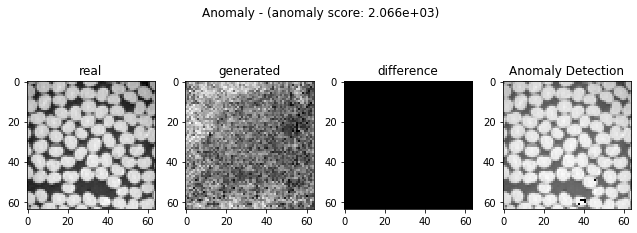

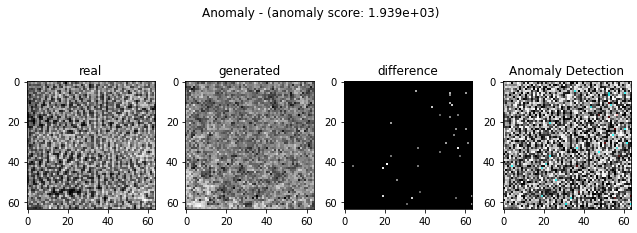

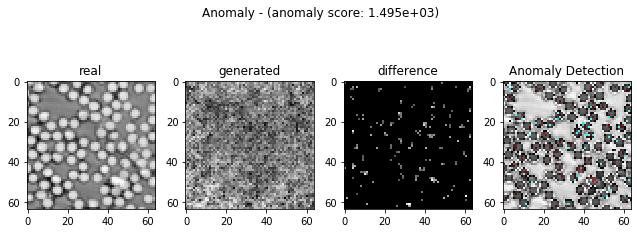

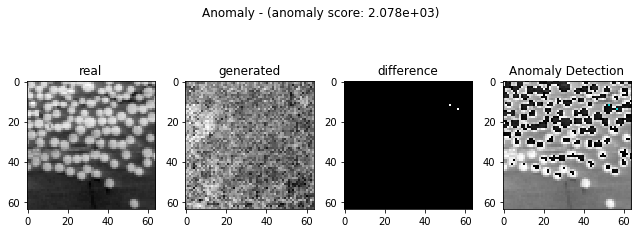

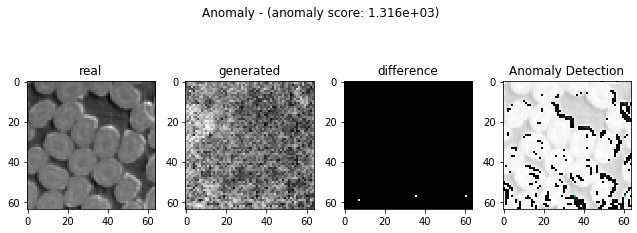

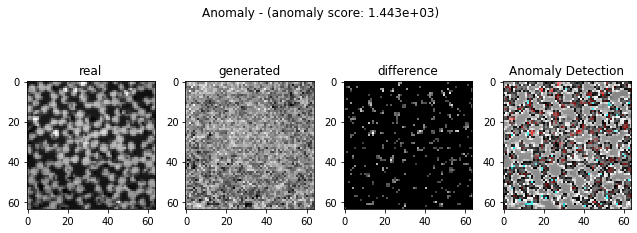

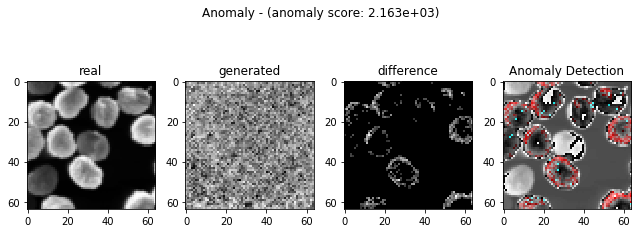

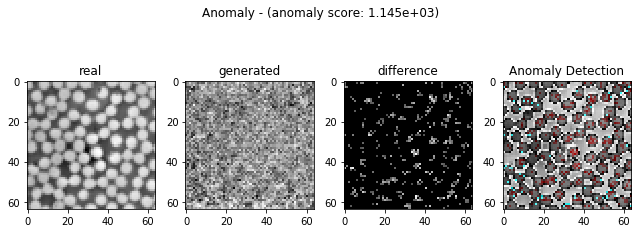

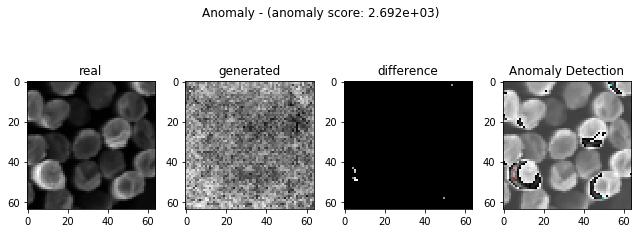

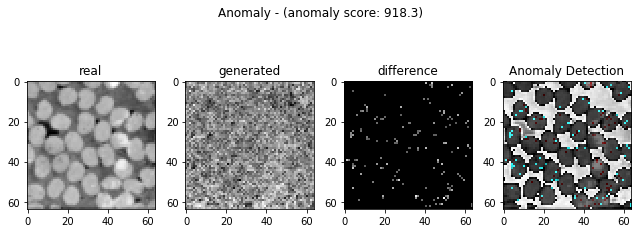

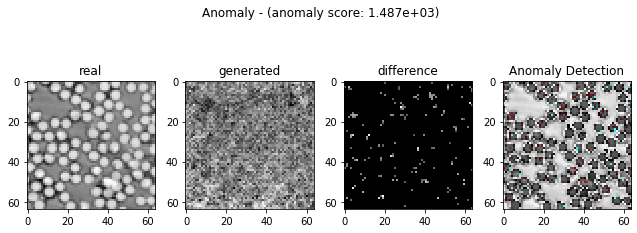

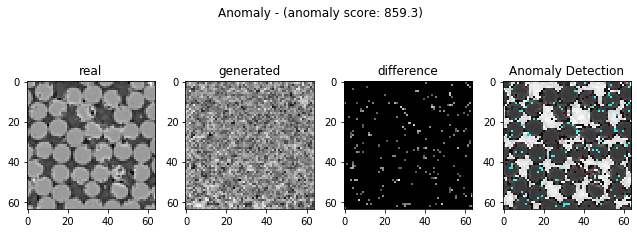

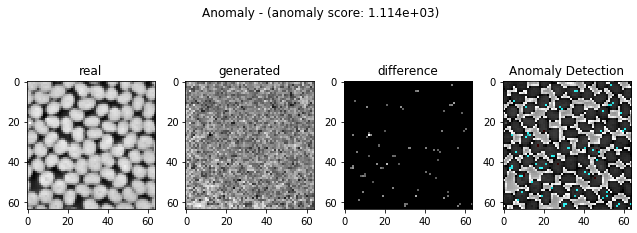

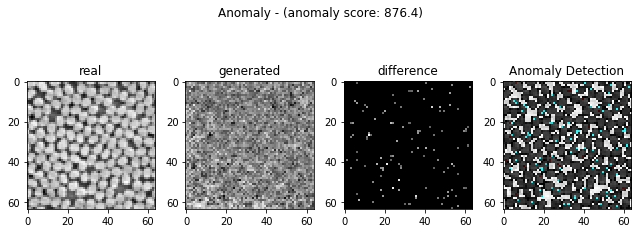

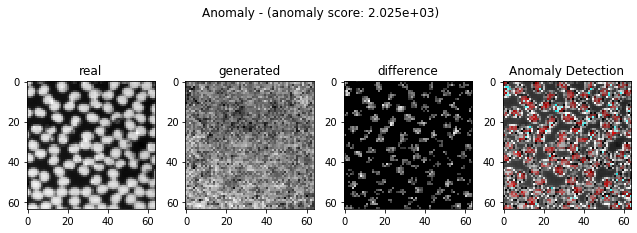

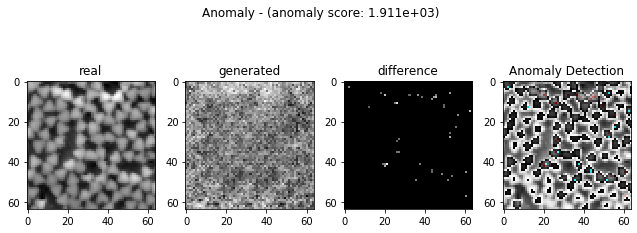

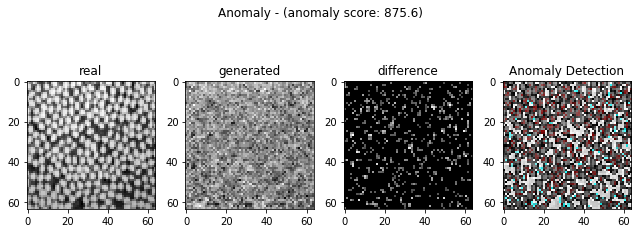

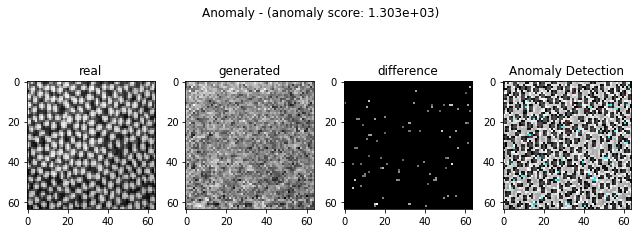

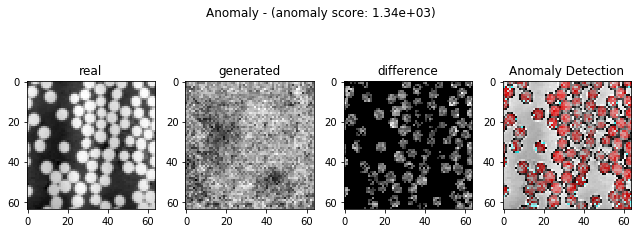

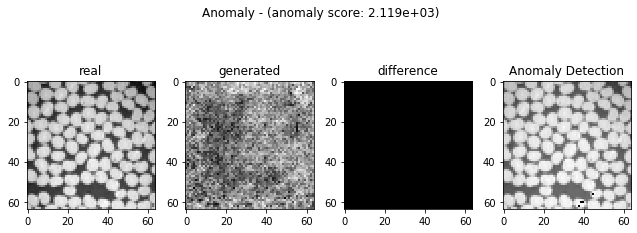

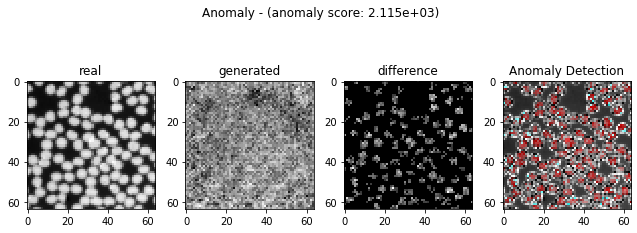

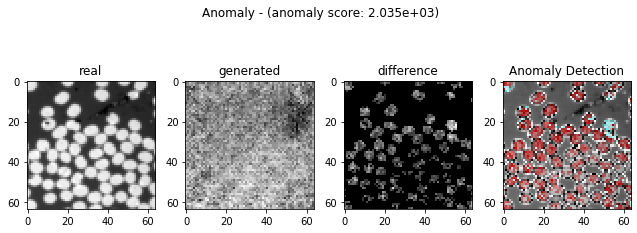

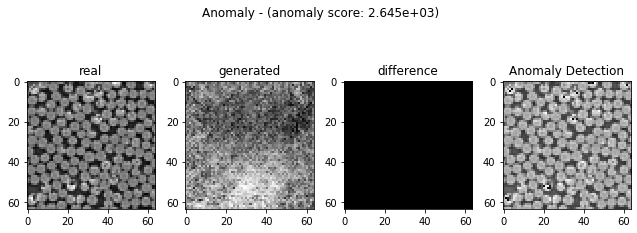

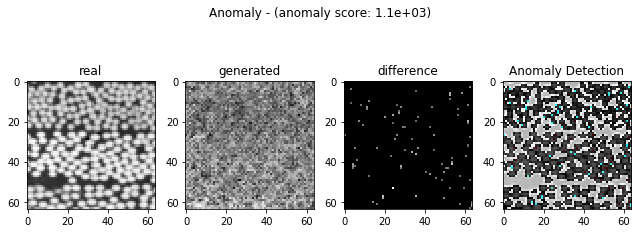

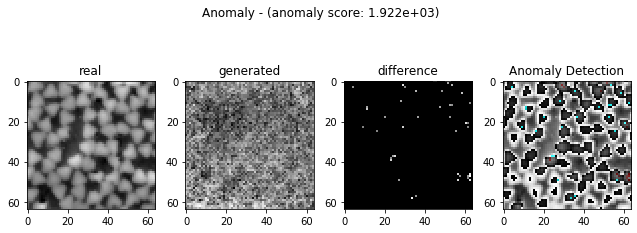

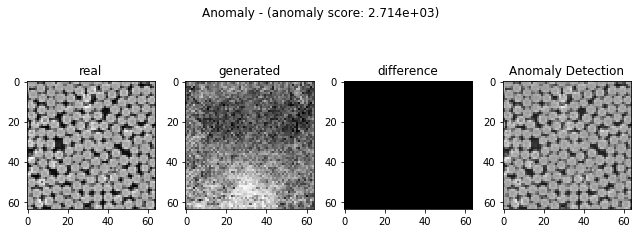

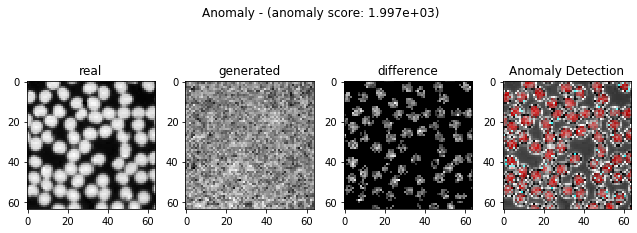

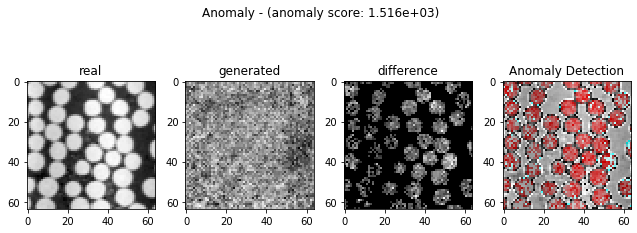

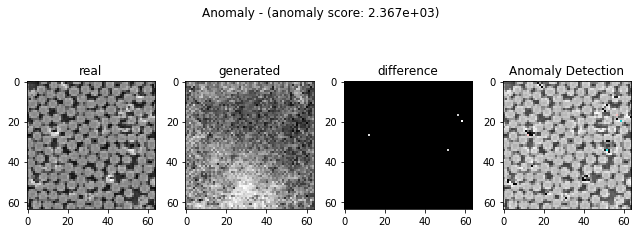

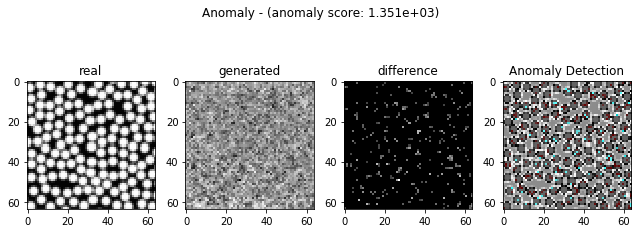

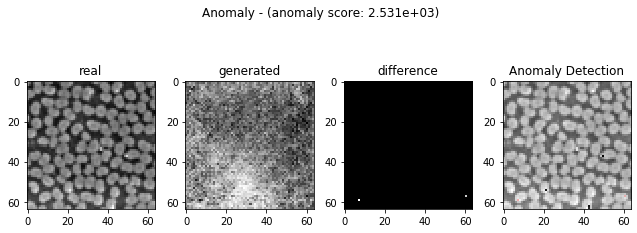

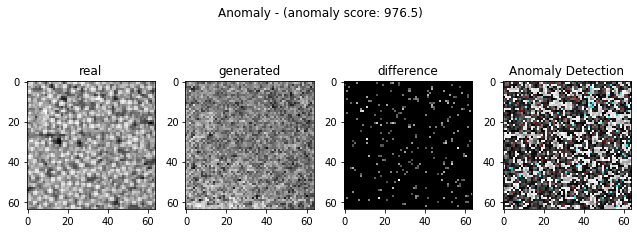

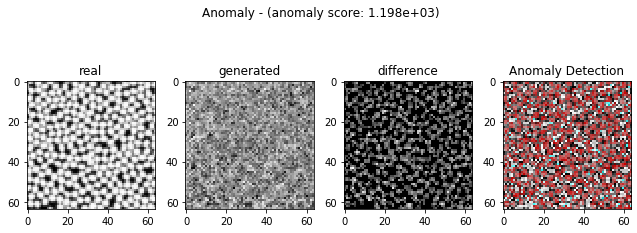

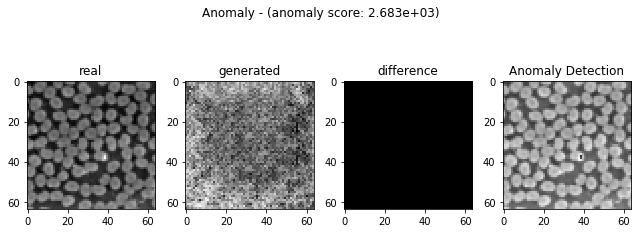

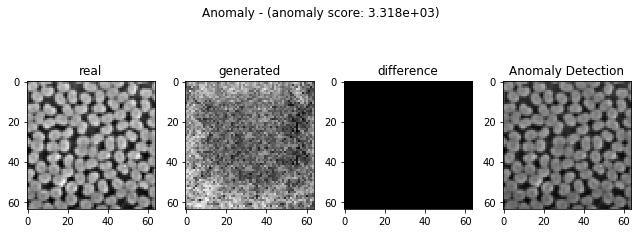

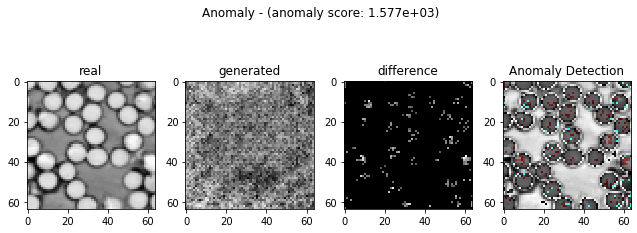

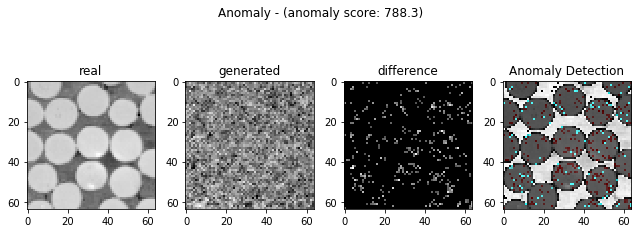

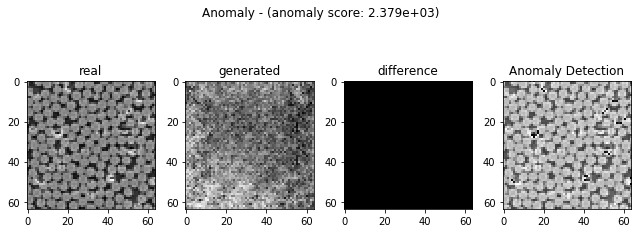

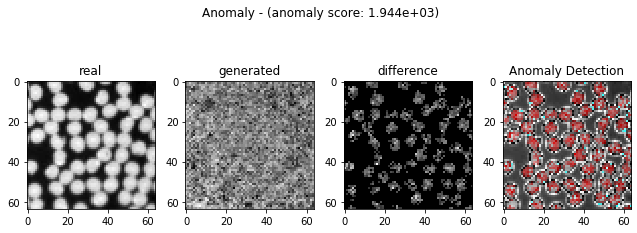

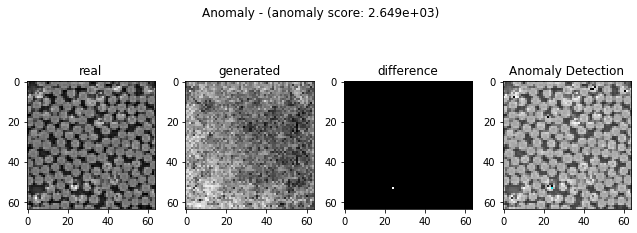

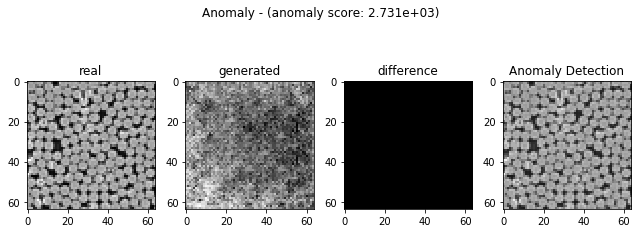

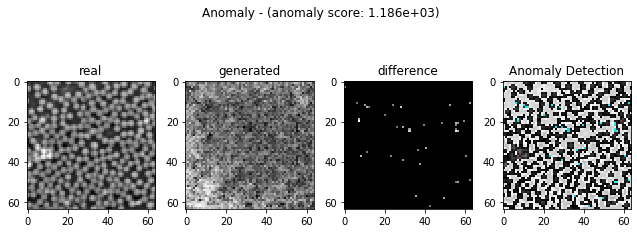

In [17]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.00000000e+00 7.03125000e-02 7.56835938e-03 4.22363281e-02
 1.38427734e-01 8.05664062e-03 3.22509766e-01 2.58300781e-01
 4.24804688e-02 5.82275391e-01 3.90625000e-02 0.00000000e+00
 2.39257812e-02 2.31933594e-02 2.36816406e-01 4.88281250e-04
 7.32421875e-04 7.32421875e-04 1.06689453e-01 9.47265625e-02
 1.07421875e-02 1.23046875e-01 1.12792969e-01 2.19726562e-03
 3.54003906e-02 3.95507812e-02 4.73632812e-02 1.58691406e-02
 2.66113281e-02 2.27294922e-01 4.51660156e-02 8.30078125e-03
 1.23535156e-01 9.27734375e-03 1.60644531e-01 1.92871094e-02
 3.47900391e-01 0.00000000e+00 2.31201172e-01 2.60253906e-01
 0.00000000e+00 2.02636719e-02 1.09863281e-02 0.00000000e+00
 2.92236328e-01 3.91357422e-01 9.76562500e-04 7.15332031e-02
 4.88281250e-04 5.66406250e-02 5.28808594e-01 0.00000000e+00
 0.00000000e+00 4.90722656e-02 9.32617188e-02 0.00000000e+00
 2.87109375e-01 2.44140625e-04 0.00000000e+00 9.52148438e-03]


---

# 분산 추출

In [19]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)
        print(corr_coeffi)

In [20]:
cal_corr_coeffis()

print(corr_coeffis)

-inf
-0.1149261936004522
0.035890635810225585
0.20363596836575304
-0.04866501787487853
-0.3024636489149915
0.07014992223817729
0.04058655787185832
-0.036760285266348926
-0.06011953297663781
0.01004161310791514
-inf
0.212780383297928
0.19104990526384708
0.038351459100249924
1.0
-0.881894701526418
-0.5999004247935406
0.3487023371461896
0.03340522455555598
0.2829770695578845
0.10197916352042193
-0.08580468792354304
-0.49898562976043
0.06645475482545235
-0.08264942185841098
-0.07845069181751138
-0.07633009611132069
0.058418960739029295
0.03283952269299742
0.030361090400530866
-0.021867099501932025
0.10801971213980789
0.1663844392474399
-0.03041396012389381
-0.2309845436965822
0.04312460090108984
-inf
-0.02667944111447406
0.07021489086657146
-inf
0.14885908444348236
0.10527613273748397
-inf
0.011654902390042604
0.07194728850248014
-0.3367894884779411
0.023740776540124187
-1.0
0.08702743506242495
0.021409825428727658
-inf
-inf
0.07749432712832768
-0.005743648960501096
-inf
0.0950395712404692

ValueError: x and y must have length at least 2.

---

# 모델 저장 및 읽기

In [21]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [22]:
save_pretrained()

In [23]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [24]:
load_pretrained()

In [25]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [26]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [27]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1266.3403  Sum_of_z : -3.3242
[200]	 Ano_loss : 1264.7040  Sum_of_z : 0.9610
[400]	 Ano_loss : 1264.6361  Sum_of_z : 1.0947
picture  2
[0]	 Ano_loss : 1201.3168  Sum_of_z : 1.3532
[200]	 Ano_loss : 1199.7808  Sum_of_z : 11.9149
[400]	 Ano_loss : 1199.6984  Sum_of_z : 12.8498
picture  3
[0]	 Ano_loss : 1015.5364  Sum_of_z : 12.9203
[200]	 Ano_loss : 1013.7377  Sum_of_z : 6.7273
[400]	 Ano_loss : 1013.6226  Sum_of_z : -1.5176
picture  4
[0]	 Ano_loss : 524.4009  Sum_of_z : -1.5813
[200]	 Ano_loss : 523.0158  Sum_of_z : -6.6464
[400]	 Ano_loss : 522.9283  Sum_of_z : -4.0442
picture  5
[0]	 Ano_loss : 1090.5264  Sum_of_z : -4.1989
[200]	 Ano_loss : 1090.0314  Sum_of_z : -11.3059
[400]	 Ano_loss : 1090.0150  Sum_of_z : -12.8962
picture  6
[0]	 Ano_loss : 345.9109  Sum_of_z : -12.8769
[200]	 Ano_loss : 344.4709  Sum_of_z : 4.4213
[400]	 Ano_loss : 344.2828  Sum_of_z : 12.5208
picture  7
[0]	 Ano_loss : 671.7592  Sum_of_z : 12.4988
[200]	 Ano_loss : 670.0259  Sum_of

In [28]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

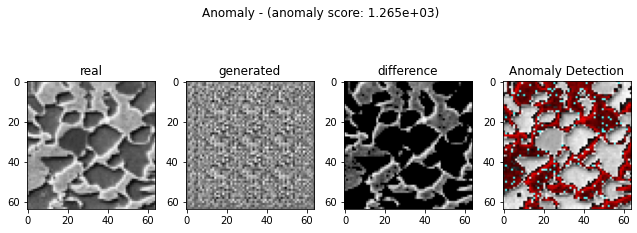

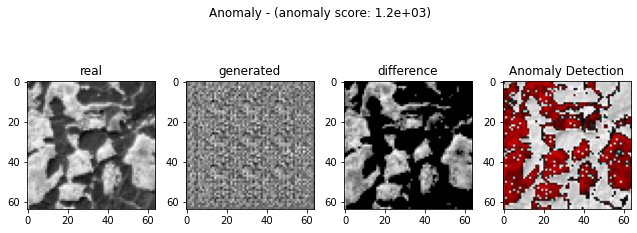

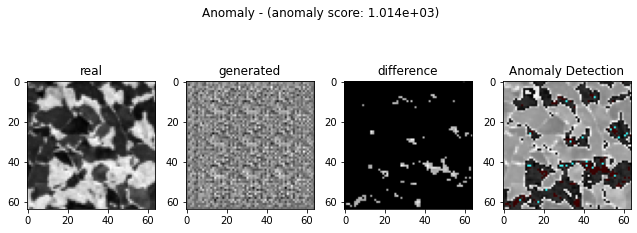

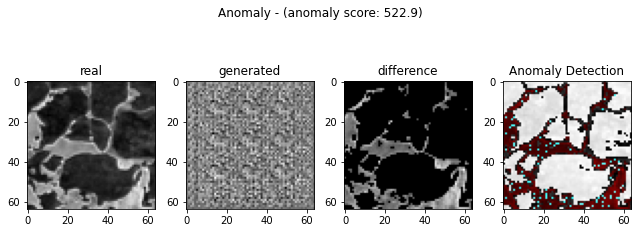

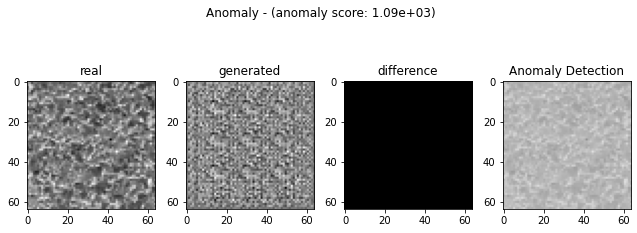

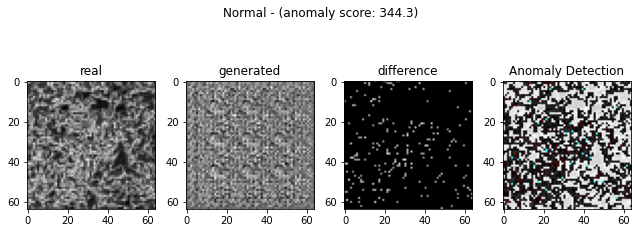

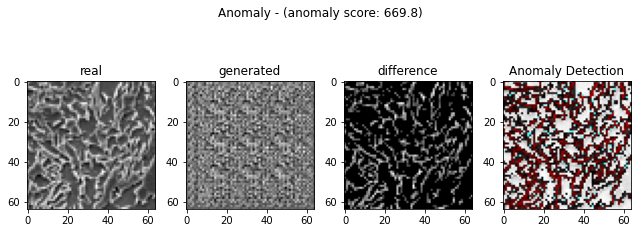

In [29]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [30]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.42578125 0.46264648 0.04516602 0.2355957  0.         0.04980469
 0.29760742]


In [31]:
cal_corr_coeffis()

print(corr_coeffis)

[0.03930323451955458, 0.09824271107967668, -0.28914111459826475, 0.19809595979534306, -inf, 0.04507935167666852, -0.08497257982755216]


---

# anomaly detection 이미지 추출

In [32]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,   0,   0],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,   1,   1],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,   3,   3],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [33]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [34]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [35]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.88621094 2.04952393 0.20008545 1.04368896 0.         0.22063477
 1.31840088]
